In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.
You should consider upgrading via the 'c:\dev\resnet18-vae\venv39\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install torchinfo torch-summary matplotlib scipy opencv-python

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.
You should consider upgrading via the 'c:\dev\resnet18-vae\venv39\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import cv2
import numpy as np

dataset_name = "cxr8"

base_data_path = Path("D:\\") / "data"

imagenet_data_path = (
    base_data_path
    / "imagenet-object-localization-challenge"
    / "ILSVRC"
    / "Data"
    / "CLS-LOC"
)

cxr8_data_path = base_data_path / "cxr8" / "filtered"

CLAHE_TILE = 8
clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(CLAHE_TILE, CLAHE_TILE))


def applyClahe(tensor):
    # print(type(tensor), tensor.size)
    return clahe.apply(np.array(tensor))


input_size = (1, 448, 448)

if dataset_name == "cxr8":
    train_dataset = datasets.ImageFolder(
        cxr8_data_path,
        transform=transforms.Compose(
            [
                transforms.Resize((input_size[1], input_size[2])),
                transforms.Grayscale(),
                transforms.Lambda(np.array),
                transforms.Lambda(clahe.apply),
                transforms.ToTensor(),
            ]
        ),
    )
elif dataset_name == "cifar10":
    train_dataset = datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((224, 224)), transforms.ToTensor()]
        ),
    )
elif dataset_name == "imagenet":
    train_dataset = datasets.ImageFolder(
        imagenet_data_path,
        transform=transforms.Compose(
            [transforms.Resize((224, 224)), transforms.ToTensor()]
        ),
    )

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [4]:
import torch
from torchinfo import summary

from vae import VAE, vae_loss

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

KERNEL_SIZE = 11
DIRECTIONS = 7
LATENT_DIM = 32  # 64

# model = VAE((1 if dataset_name == "cxr8" else 3, 224, 224), latent_dim).to(device)
model = VAE(input_size, init_kernel_size=KERNEL_SIZE, latent_dim=LATENT_DIM)
model = model.to(device)

show_summary = True
if show_summary:
    print(
        summary(
            model,
            input_size=(37, input_size[0], input_size[1], input_size[2]),
            depth=10,
            col_names=[
                "input_size",
                "kernel_size",
                "mult_adds",
                "num_params",
                "output_size",
                "trainable",
            ],
        )
    )

import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)


make_oriented_map: weights_real.shape = torch.Size([40, 1, 11, 11])
make_oriented_map: weights_real.shape = torch.Size([40, 1, 11, 11])
self.input_size_to_fc = [512, 7, 7]
torch.Size([37, 1, 448, 448])
torch.Size([37, 40, 448, 448])
torch.Size([37, 10, 110, 110])
Layer (type:depth-idx)                             Input Shape               Kernel Shape              Mult-Adds                 Param #                   Output Shape              Trainable
VAE                                                [37, 1, 448, 448]         --                        --                        --                        [37, 1, 448, 448]         Partial
├─Conv2d: 1-1                                      [37, 1, 448, 448]         [11, 11]                  35,942,072,320            (4,840)                   [37, 40, 448, 448]        False
├─Conv2d: 1-2                                      [37, 1, 448, 448]         [11, 11]                  35,942,072,320            (4,840)                   [37, 40, 448, 

c:\dev\resnet18-vae\venv39\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\dev\resnet18-vae\venv39\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\dev\resnet18-vae\venv39\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lamb

In [5]:
print(device)
model.to(device)
print(set([p.device for p in model.parameters()]))


cuda
{device(type='cuda', index=0)}


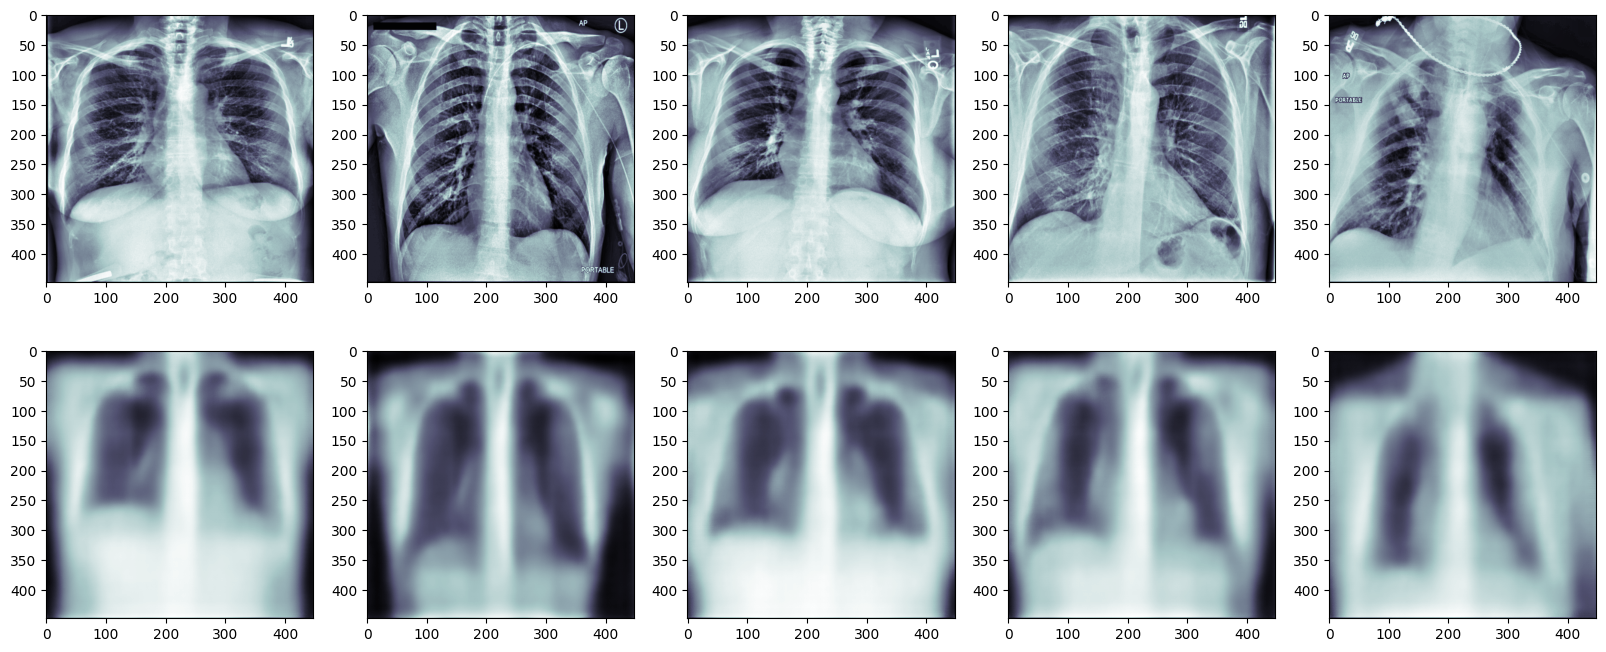

Epoch [5/5], Batch: 940, Loss: 0.132016 (0.118157/0.180800)
torch.Size([64, 1, 448, 448])
torch.Size([64, 40, 448, 448])
torch.Size([64, 10, 110, 110])
Epoch [5/5], Batch: 941, Loss: 0.132015 (0.114665/0.161647)
torch.Size([64, 1, 448, 448])
torch.Size([64, 40, 448, 448])
torch.Size([64, 10, 110, 110])
Epoch [5/5], Batch: 942, Loss: 0.132017 (0.118108/0.160175)
torch.Size([9, 1, 448, 448])
torch.Size([9, 40, 448, 448])
torch.Size([9, 10, 110, 110])
Epoch [5/5], Batch: 943, Loss: 0.132027 (0.121173/0.202298)


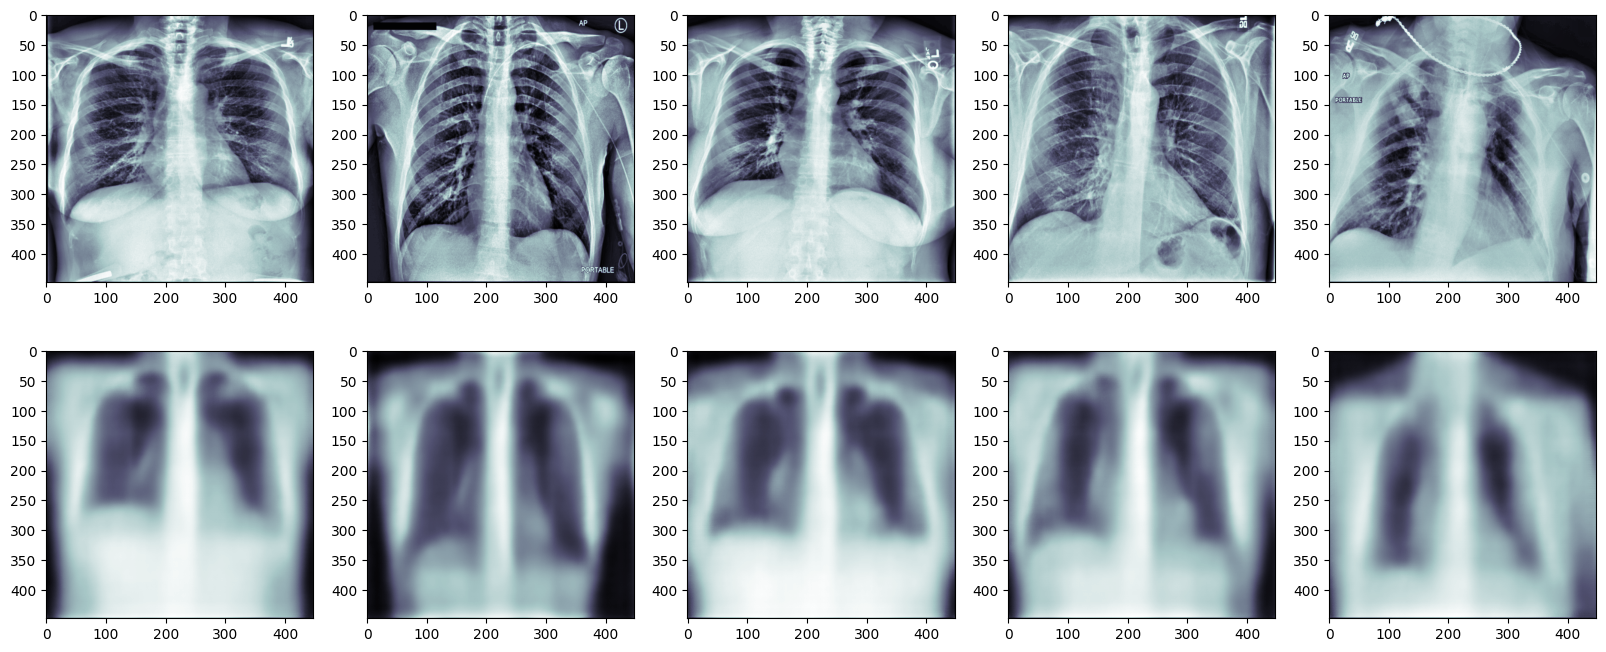

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch.nn.functional as F

num_epochs = 5

fig, ax = plt.subplots(2, 5, figsize=(20,8))

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_count = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        recon_loss, kldiv_loss, loss = vae_loss(
            recon_batch, data, mu, log_var, beta=0.1
        )

        if train_count % 10 == 0:
            orig_data = data.clone().cpu().detach().numpy()
            recon_data = recon_batch.cpu().detach().numpy()

            # print(v.shape)
            for n in range(5):
                ax[0][n].imshow(torch.movedim(torch.tensor(orig_data[n]), 0, -1), cmap='bone')
                ax[1][n].imshow(torch.movedim(torch.tensor(recon_data[n]), 0, -1), cmap='bone')

            clear_output(wait=True)

            display(plt.gcf())

        loss.backward()
        train_loss += loss.item()
        train_count += 1.0
        optimizer.step()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Batch: {batch_idx}, Loss: {train_loss / train_count:.6f} ({recon_loss:.6f}/{kldiv_loss:.6f})"
        )
        

In [7]:
from datetime import datetime

when = datetime.now().strftime("%Y%m%d%H%M%S")
weight_path = (
    Path("weights")
    / f"{when}_clahe{CLAHE_TILE}_kernel{KERNEL_SIZE}_latent{LATENT_DIM}_orisq.zip"
)

torch.save(model.state_dict(), weight_path)
